# FTRL, One-Hot Bucketing and Feature Crosses:

Collab link: https://colab.research.google.com/notebooks/mlcc/feature_crosses.ipynb

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')

chdf = chdf.reindex(np.random.permutation(chdf.index))


In [0]:
# Preprocessing the features:
def preprocess_features(df):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = df[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]

  # print mean for each pd column:
  # print(selected_features.mean())
  # print(selected_features.std())

  processed_features = selected_features.copy()
  # Create a synthetic feature:
  processed_features['rooms_per_person'] = df['total_rooms'] / df['population']

  # Scaling the features:
  processed_features -= processed_features.mean()
  processed_features /= processed_features.std()

  return processed_features


# Preprocessing the labels:
def preprocess_targets(df):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()  # just to initialise the pd dataframe
  # Scale the target to be in units of thousands of dollars.
  output_targets['median_house_value'] = df['median_house_value'] / 1000.0

  return output_targets


In [0]:
def TrainValTestDataSplit(feat_df, targ_df, train_percentage, val_percentage, test_percentage):

  # Data reshuffled randomly, just in case it hasn't been done yet:
  my_index = np.random.permutation(feat_df.index)
  feat_df = feat_df.reindex(my_index)
  targ_df = targ_df.reindex(my_index)

  # Training, Validation and Test dataset sizes:
  m_train = int(train_percentage*feat_df.shape[0])
  m_test = int(test_percentage*feat_df.shape[0])
  m_val = feat_df.shape[0] - m_train - m_test


  # Splitting DF into training and validation sets:
  training_examples = feat_df.head(m_train)
  training_targets = targ_df.head(m_train)
 
  validation_examples = feat_df.iloc[m_train:m_train+m_val] 
  validation_targets = targ_df.iloc[m_train:m_train+m_val]

  test_examples = feat_df.tail(m_test)  # we take the last examples using the tail command
  test_targets = targ_df.tail(m_test)

  return training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets


In [0]:
def FeatureScaling(df):
  
  # Scaling the features:
  scaled_features -= df.mean()
  scaled_features /= scaled_features.std()

  return scaled_features


In [0]:
def BinFeature(df, feature_col, ends):
  """ Function to bin a feature into ranges from end to end:
      - df: dataframe
      - feature_col: name of the feature that needs binning
      - ends: a 2 array vector with the lower and upper ends.
  """

  # Creating the bin ranges with a zip:    
  ranges = zip(range(ends[0], ends[1]), range(ends[0]+1, ends[1]+1))

  # Splitting the feature into the different bins:
  for r in ranges:
    df[feature_col+"_%d_to_%d" %r] = df[feature_col].apply(lambda val : 1.0 if val>=r[0] and val<r[1] else 0.0 )

  # Removing the non-binned feature:
  del df[feature_col]

  return df
  

In [0]:
# Input function:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()  ## TF 1!!!

    return features, labels


# Defining feature columns:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.

    Args:
      input_features: The names of the numerical input features to use.
    Returns:
      A set of feature columns
    """ 
    # return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])  
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])   # set is not needed

# print(construct_feature_columns(training_examples))


# FTRL Optimisation Algorithm:

High dimensional linear models benefit from using a variant of gradient-based optimization called FTRL. This algorithm has the benefit of scaling the learning rate differently for different coefficients, which can be useful if some features rarely take non-zero values (it also is well suited to support L1 regularization). We can apply FTRL using the [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer).

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.  ## FTRL Optimiser ##
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, training_targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets, batch_size=1, num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets, batch_size=1, num_epochs=1, shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(training_predictions, training_targets) )
    validation_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(validation_predictions, validation_targets) )
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()
  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(training_predictions, training_targets.values, '.', label='training predicted vs reality' )
  plt.plot(validation_predictions, validation_targets.values, '.', label='validation predicted vs reality')
  plt.legend()
  plt.grid()
  plt.ylabel("targetss")
  plt.xlabel("predictions")
  plt.title("Predicted vs Targets")

  plt.show()


  return linear_regressor

In [0]:
# Loading the data:
chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')
chdf = chdf.reindex(np.random.permutation(chdf.index))


# Processing the data:
pchdf = preprocess_features(chdf)  # def preprocess_features
ochdf = preprocess_targets(chdf)

print(pchdf.head())
print(ochdf.head())


# Chosen features:
chosen_features = ['latitude', 'median_income']
pchdf = pchdf[chosen_features]


# Binning 'Latitude' feature:
# pchdf['latitude bin 1'] = 0.0
# pchdf['latitude bin 2'] = 0.0
# pchdf['latitude bin 3'] = 0.0
# pchdf['latitude bin 4'] = 0.0
# pchdf['latitude bin 5'] = 0.0

# pchdf['latitude bin 1'].loc[pchdf['latitude']<-1] = 1.0
# pchdf['latitude bin 2'].loc[(pchdf.latitude>=-1) & (pchdf['latitude']<0)] = 1.0
# pchdf['latitude bin 3'].loc[(pchdf['latitude']>=0) & (pchdf.latitude<1)] = 1.0
# pchdf['latitude bin 4'].loc[(pchdf.latitude>=1) & (pchdf.latitude<2)] = 1.0
# pchdf['latitude bin 5'].loc[pchdf['latitude']>=2] = 1.0
pchdf = BinFeature(pchdf, 'latitude', [-2, 3])   # def BinFeature

display.display(pchdf.head())


# Splitting the dataframe (total must sum 1!!!):
train_percentage = 0.75
val_percentage = 0.25
test_percentage = 0.0

[training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets] = TrainValTestDataSplit(pchdf, ochdf, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit


# Describing the different data sets:
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Test examples summary:")
display.display(test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())


# Creating the feature columns:
feature_columns = construct_feature_columns(training_examples)


       latitude  longitude  ...  median_income  rooms_per_person
13540       1.3       -1.2  ...            0.1               0.2
10635       0.8       -0.5  ...           -0.4               0.1
15288       1.0       -1.4  ...           -0.8               0.2
2899       -0.8        0.9  ...            1.4               0.3
10936       1.7       -0.7  ...            0.0               0.7

[5 rows x 9 columns]
       median_house_value
13540               126.8
10635               118.3
15288               152.7
2899                270.5
10936               142.7


,median_income,latitude_-2_to_-1,latitude_-1_to_0,latitude_0_to_1,latitude_1_to_2,latitude_2_to_3
13540,0.1,0.0,0.0,0.0,1.0,0.0
10635,-0.4,0.0,0.0,1.0,0.0,0.0
15288,-0.8,0.0,0.0,0.0,1.0,0.0
2899,1.4,0.0,1.0,0.0,0.0,0.0
10936,0.0,0.0,0.0,0.0,1.0,0.0


Training examples summary:


,median_income,latitude_-2_to_-1,latitude_-1_to_0,latitude_0_to_1,latitude_1_to_2,latitude_2_to_3
count,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0
mean,-0.0,0.1,0.5,0.2,0.2,0.0
std,1.0,0.3,0.5,0.4,0.4,0.1
min,-1.8,0.0,0.0,0.0,0.0,0.0
25%,-0.7,0.0,0.0,0.0,0.0,0.0
50%,-0.2,0.0,0.0,0.0,0.0,0.0
75%,0.5,0.0,1.0,0.0,0.0,0.0
max,5.8,1.0,1.0,1.0,1.0,1.0


Validation examples summary:


,median_income,latitude_-2_to_-1,latitude_-1_to_0,latitude_0_to_1,latitude_1_to_2,latitude_2_to_3
count,4250.0,4250.0,4250.0,4250.0,4250.0,4250.0
mean,0.0,0.1,0.5,0.2,0.2,0.0
std,1.0,0.3,0.5,0.4,0.4,0.1
min,-1.8,0.0,0.0,0.0,0.0,0.0
25%,-0.7,0.0,0.0,0.0,0.0,0.0
50%,-0.2,0.0,0.0,0.0,0.0,0.0
75%,0.5,0.0,1.0,0.0,0.0,0.0
max,5.8,1.0,1.0,1.0,1.0,1.0


Test examples summary:


,median_income,latitude_-2_to_-1,latitude_-1_to_0,latitude_0_to_1,latitude_1_to_2,latitude_2_to_3
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,nan,nan,nan,nan,nan,nan
std,nan,nan,nan,nan,nan,nan
min,nan,nan,nan,nan,nan,nan
25%,nan,nan,nan,nan,nan,nan
50%,nan,nan,nan,nan,nan,nan
75%,nan,nan,nan,nan,nan,nan
max,nan,nan,nan,nan,nan,nan


Training targets summary:


,median_house_value
count,12750.0
mean,206.7
std,116.2
min,15.0
25%,118.9
50%,179.2
75%,264.3
max,500.0


Validation targets summary:


,median_house_value
count,4250.0
mean,209.2
std,115.3
min,17.5
25%,121.4
50%,183.2
75%,266.7
max,500.0


Test targets summary:


,median_house_value
count,0.0
mean,nan
std,nan
min,nan
25%,nan
50%,nan
75%,nan
max,nan


Training model...
RMSE (on training data):
  period 00 : 161.93
  period 01 : 131.35
  period 02 : 110.78
  period 03 : 97.06
  period 04 : 88.38
  period 05 : 84.15
  period 06 : 82.94
  period 07 : 82.74
  period 08 : 82.70
  period 09 : 82.69
Model training finished.


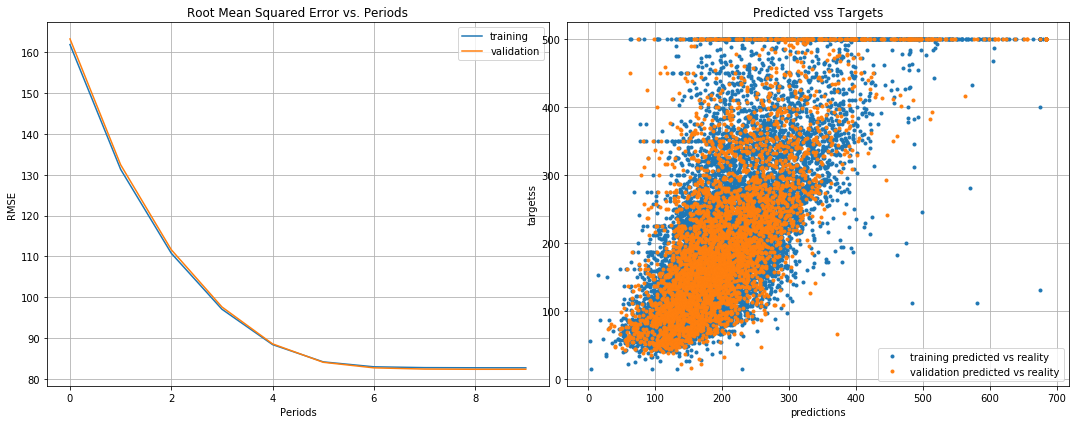

In [0]:
# Call the training model:
learning_rate = 3.0 #0.6
steps = 500
batch_size = 100 #5

linear_regression = train_model(
    learning_rate=learning_rate,
    steps=steps,
    batch_size=batch_size,
    feature_columns=feature_columns,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## One-Hot Encoding for Discrete Features

Discrete (i.e. strings, enumerations, integers) features are usually converted into families of binary features before training a logistic regression model.

For example, suppose we created a synthetic feature that can take any of the values `0`, `1` or `2`, and that we have a few training points:

| # | feature_value |
|---|---------------|
| 0 |             2 |
| 1 |             0 |
| 2 |             1 |

For each possible categorical value, we make a new **binary** feature of **real values** that can take one of just two possible values: 1.0 if the example has that value, and 0.0 if not. In the example above, the categorical feature would be converted into three features, and the training points now look like:

| # | feature_value_0 | feature_value_1 | feature_value_2 |
|---|-----------------|-----------------|-----------------|
| 0 |             0.0 |             0.0 |             1.0 |
| 1 |             1.0 |             0.0 |             0.0 |
| 2 |             0.0 |             1.0 |             0.0 |

# Bucketised (or Binned) Features

Binning is grouping the feature values into groups.
Then, these must be converted to binary (one-hot) features as if they were discrete.

The feature values are now the bucket indices. Note that these indices are considered to be discrete features. Typically, these will be further converted in one-hot representations as above, but this is done transparently.

To define feature columns for bucketized features, instead of using `numeric_column`, we can use [`bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column), which takes a numeric column as input and transforms it to a bucketized feature using the bucket boundaries specified in the `boundaries` argument. The following code defines bucketized feature columns for `households`; the `get_quantile_based_boundaries` function calculates boundaries based on quantiles, so that each bucket contains an equal number of elements.

There are various heuristics to find the range of the buckets. This exercise uses a quantile-based technique, which chooses the bucket boundaries in such a way that each bucket has the same number of examples.

In [0]:
# Bucketising (binning) a feature with the quantiles:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [quantiles[q] for q in quantiles.keys()]


# Example on how to bucketise a feature:
# Divide households into 7 buckets.
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column( households, boundaries=get_quantile_based_boundaries(chdf["households"], 7) )



Construct the Feature Columns for bucketised features:

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  # One way to automitise the numeric columning:
  #set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column( households, boundaries = get_quantile_based_boundaries(training_examples["households"], 7) )

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column( longitude, boundaries = get_quantile_based_boundaries(training_examples["longitude"], 10) )

  bucketized_latitude = tf.feature_column.bucketized_column( latitude, boundaries = get_quantile_based_boundaries(training_examples['latitude'], 10) )
  bucketized_housing_median_age = tf.feature_column.bucketized_column( housing_median_age, boundaries = get_quantile_based_boundaries(training_examples['housing_median_age'], 7) )
  bucketized_median_income = tf.feature_column.bucketized_column( median_income, boundaries = get_quantile_based_boundaries(training_examples['median_income'], 7) )
  bucketized_rooms_per_person = tf.feature_column.bucketized_column( rooms_per_person, boundaries=get_quantile_based_boundaries(training_examples['rooms_per_person'], 7) )
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns


In [0]:
# Loading the data:
chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')
chdf = chdf.reindex(np.random.permutation(chdf.index))


# Processing the data:
pchdf = preprocess_features(chdf)  # def preprocess_features
ochdf = preprocess_targets(chdf)

print(pchdf.head())
print(ochdf.head())


# Chosen features:
chosen_features = ['households', 'longitude', 'latitude', 'housing_median_age', 'median_income', 'rooms_per_person']
pchdf = pchdf[chosen_features]


# Binning 'Latitude' feature:   # bucketised in feature columns
# pchdf['latitude bin 1'] = 0.0
# pchdf['latitude bin 2'] = 0.0
# pchdf['latitude bin 3'] = 0.0
# pchdf['latitude bin 4'] = 0.0
# pchdf['latitude bin 5'] = 0.0

# pchdf['latitude bin 1'].loc[pchdf['latitude']<-1] = 1.0
# pchdf['latitude bin 2'].loc[(pchdf.latitude>=-1) & (pchdf['latitude']<0)] = 1.0
# pchdf['latitude bin 3'].loc[(pchdf['latitude']>=0) & (pchdf.latitude<1)] = 1.0
# pchdf['latitude bin 4'].loc[(pchdf.latitude>=1) & (pchdf.latitude<2)] = 1.0
# pchdf['latitude bin 5'].loc[pchdf['latitude']>=2] = 1.0
# pchdf = BinFeature(pchdf, 'latitude', [-2, 3])   # def BinFeature

# display.display(pchdf.head())


# Splitting the dataframe (total must sum 1!!!):
train_percentage = 0.75
val_percentage = 0.25
test_percentage = 0.0

[training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets] = TrainValTestDataSplit(pchdf, ochdf, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit


# Describing the different data sets:
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Test examples summary:")
display.display(test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())


# Creating the feature columns:
feature_columns = construct_feature_columns()



       latitude  longitude  ...  median_income  rooms_per_person
9102       -0.7        0.3  ...            0.8               1.0
4123       -0.9        0.8  ...           -0.0              -0.5
4542       -0.8        0.8  ...           -0.9              -0.3
15026       1.2       -1.3  ...           -0.6               0.2
15517       2.3       -1.4  ...           -0.0               0.1

[5 rows x 9 columns]
       median_house_value
9102                428.6
4123                180.0
4542                375.0
15026               109.9
15517               111.1
Training examples summary:


,households,longitude,latitude,housing_median_age,median_income,rooms_per_person
count,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0
mean,0.0,0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.1
min,-1.3,-2.4,-1.4,-2.2,-1.8,-1.6
25%,-0.6,-1.1,-0.8,-0.8,-0.7,-0.4
50%,-0.2,0.5,-0.6,0.0,-0.2,-0.0
75%,0.3,0.8,1.0,0.7,0.5,0.3
max,14.5,2.6,3.0,1.9,5.8,45.5


Validation examples summary:


,households,longitude,latitude,housing_median_age,median_income,rooms_per_person
count,4250.0,4250.0,4250.0,4250.0,4250.0,4250.0
mean,-0.0,-0.0,0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,0.7
min,-1.3,-2.4,-1.4,-2.2,-1.8,-1.7
25%,-0.6,-1.1,-0.8,-0.8,-0.7,-0.4
50%,-0.2,0.5,-0.6,0.0,-0.2,-0.0
75%,0.3,0.8,1.0,0.7,0.5,0.3
max,11.1,2.5,3.0,1.9,5.8,12.7


Test examples summary:


,households,longitude,latitude,housing_median_age,median_income,rooms_per_person
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,nan,nan,nan,nan,nan,nan
std,nan,nan,nan,nan,nan,nan
min,nan,nan,nan,nan,nan,nan
25%,nan,nan,nan,nan,nan,nan
50%,nan,nan,nan,nan,nan,nan
75%,nan,nan,nan,nan,nan,nan
max,nan,nan,nan,nan,nan,nan


Training targets summary:


,median_house_value
count,12750.0
mean,207.0
std,115.8
min,15.0
25%,119.1
50%,180.3
75%,264.7
max,500.0


Validation targets summary:


,median_house_value
count,4250.0
mean,208.2
std,116.5
min,15.0
25%,120.2
50%,180.5
75%,266.3
max,500.0


Test targets summary:


,median_house_value
count,0.0
mean,nan
std,nan
min,nan
25%,nan
50%,nan
75%,nan
max,nan


Training model...
RMSE (on training data):
  period 00 : 94.52
  period 01 : 79.57
  period 02 : 74.53
  period 03 : 72.01
  period 04 : 70.76
  period 05 : 69.96
  period 06 : 69.45
  period 07 : 69.14
  period 08 : 68.88
  period 09 : 68.71
Model training finished.


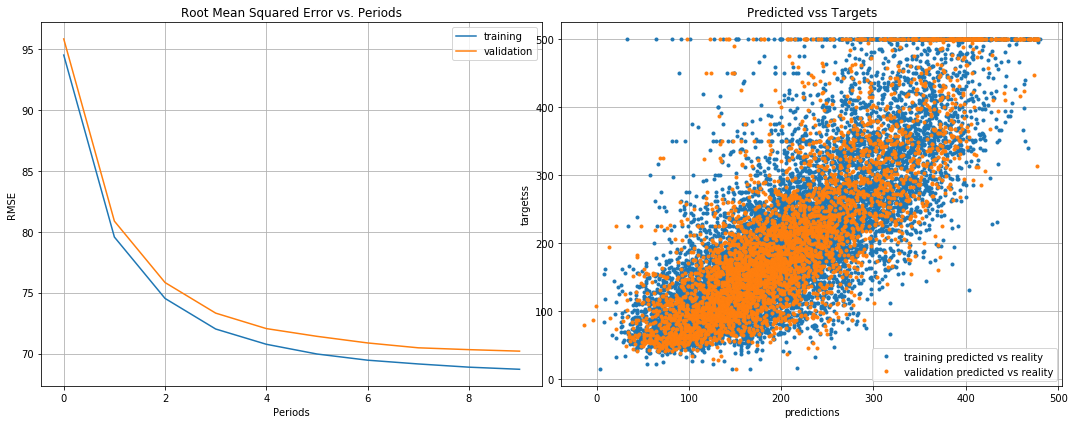

In [0]:
# Call the training model:
learning_rate = 3.0 #0.6
steps = 500
batch_size = 100 #5

linear_regression = train_model(
    learning_rate=learning_rate,
    steps=steps,
    batch_size=batch_size,
    feature_columns=feature_columns,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Feature Crosses

Crossing two (or more) features is a clever way to learn non-linear relations using a linear model. In our problem, if we just use the feature `latitude` for learning, the model might learn that city blocks at a particular latitude (or within a particular range of latitudes since we have bucketized it) are more likely to be expensive than others. Similarly for the feature `longitude`. However, if we cross `longitude` by `latitude`, the crossed feature represents a well defined city block. If the model learns that certain city blocks (within range of latitudes and longitudes) are more likely to be more expensive than others, it is a stronger signal than two features considered individually.

Currently, the feature columns API only supports discrete features for crosses. To cross two continuous values, like `latitude` or `longitude`, we can bucketize them.

If we cross the `latitude` and `longitude` features (supposing, for example, that `longitude` was bucketized into `2` buckets, while `latitude` has `3` buckets), we actually get six crossed binary features. Each of these features will get its own separate weight when we train the model.

## Task 2: Train the Model Using Feature Crosses

**Add a feature cross of `longitude` and `latitude` to your model, train it, and determine whether the results improve.**

Refer to the TensorFlow API docs for [`crossed_column()`](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) to build the feature column for your cross. Use a `hash_bucket_size` of `1000`.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 

  # Numerical columns of each feature:
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  # One way to automitise the numeric columning:
  #set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])
  
  # Bucketising the features in quantiles:
  bucketized_households = tf.feature_column.bucketized_column( households, boundaries = get_quantile_based_boundaries(training_examples["households"], 7) )  # Divide households into 7 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column( longitude, boundaries = get_quantile_based_boundaries(training_examples["longitude"], 10) )  # Divide longitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column( latitude, boundaries = get_quantile_based_boundaries(training_examples['latitude'], 10) )
  bucketized_housing_median_age = tf.feature_column.bucketized_column( housing_median_age, boundaries = get_quantile_based_boundaries(training_examples['housing_median_age'], 7) )
  bucketized_median_income = tf.feature_column.bucketized_column( median_income, boundaries = get_quantile_based_boundaries(training_examples['median_income'], 7) )
  bucketized_rooms_per_person = tf.feature_column.bucketized_column( rooms_per_person, boundaries=get_quantile_based_boundaries(training_examples['rooms_per_person'], 7) )
  

  ## Crossing 'longitude' and 'latitude' features:
  # long_x_lat = tf.feature_column.crossed_column( [bucketized_longitude, bucketized_latitude], hash_bucket_size=1000, hash_key=None)
  long_x_lat = tf.feature_column.crossed_column( set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000, hash_key=None)  # not sure if set is really needed


  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns


Training model...
RMSE (on training data):
  period 00 : 94.99
  period 01 : 79.86
  period 02 : 74.53
  period 03 : 72.14
  period 04 : 70.72
  period 05 : 69.94
  period 06 : 69.40
  period 07 : 69.10
  period 08 : 68.83
  period 09 : 68.63
Model training finished.


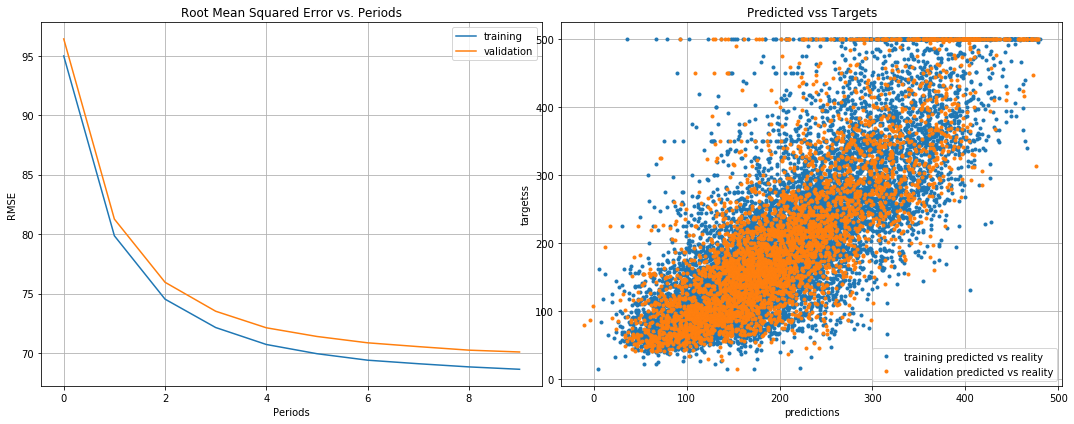

In [0]:
# Creating the feature columns:
feature_columns = construct_feature_columns()

# Call the training model:
learning_rate = 3.0 #0.6
steps = 500
batch_size = 100 #5

linear_regression = train_model(
    learning_rate=learning_rate,
    steps=steps,
    batch_size=batch_size,
    feature_columns=feature_columns,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Optional Challenge: Try Out More Synthetic Features

So far, we've tried simple bucketized columns and feature crosses, but there are many more combinations that could potentially improve the results. For example, you could cross multiple columns. What happens if you vary the number of buckets? What other synthetic features can you think of? Do they improve the model?
